<a href="https://colab.research.google.com/github/molloyjb/ExploreGIT/blob/main/assignments/homework3/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Water Balance
In this homework, you will evaluate multiple fluxes and their effect on soil water storage in several pre-defined regions, as well as in the study area of your term projeoct. You will download precipitation, ETo, and soil moisture over each region as a time series, then evaluate drivers of soil moisture.

Next, you will repeat the exercise over the watershed you have chosen for your term project.

As you go through the assignment, follow prompts to fill out a lab report in a word document. You will turn in the word document along with the code you used.

First we need to install a couple packages. If this shows an error after running, try the next code block. If it runs without an error, then you should be ok.

In [2]:
pip install geemap pycrs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.2 MB/s eta 0:00:00
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=99396808f88c54a66cfc69cdb6080ab96b6f09760b69ba562306d573dcac23ce
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built pycrs


Now we will clone the git repository, which gives us easy access to the shapefiles you will need

In [3]:
!git clone https://github.com/rg-smith/remote-sensing-hydro-2025.git

Cloning into 'remote-sensing-hydro-2025'...
remote: Enumerating objects: 761, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 761 (delta 41), reused 18 (delta 18), pack-reused 702 (from 2)
Receiving objects: 100% (761/761), 103.93 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (348/348), done.
Updating files: 100% (691/691), done.


In [4]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from tqdm import tqdm
import zipfile
import os
import pandas as pd
from glob import glob
import geemap
import folium
import branca.colormap as cm

In [5]:
# you only need to run this once per session
ee.Authenticate()
ee.Initialize(project='ee-molloyjb')

# Define custom functions

In [6]:
def add_ee_layer(self, ee_object, name):
    try:
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):
            range = ee.Image(ee_object).reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
            vals = range.getInfo()
            min=list(vals.items())[0][1]
            max=list(vals.items())[1][1]
            vis = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}

            map_id_dict = ee.Image(ee_object).getMapId(vis)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            colormap = cm.LinearColormap(vmin=min,vmax=max,colors=['blue', 'white','red']).to_step(n=10)
            colormap.caption=name
            self.add_child(colormap)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

    except Exception as e:
        print("Could not display {}".format(name))
        print(e)

# Add EE drawing method to folium (not a function)
folium.Map.add_ee_layer = add_ee_layer

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

def gee_zonal_mean_img_coll(imageCollection,geometry,scale=1000):
    reduce_iC = create_reduce_region_function(geometry = geometry, scale=scale)
    stat_fc = ee.FeatureCollection(imageCollection.map(reduce_iC)).filter(ee.Filter.notNull(imageCollection.first().bandNames()))
    fc_dict = fc_to_dict(stat_fc).getInfo()

    df = pd.DataFrame(fc_dict)
    df['date'] = pd.to_datetime(df['millis'],unit='ms')
    return(df)

def gee_zonal_mean(date1,date2,geometry,collection_name,band_name,scale=1000):
     imcol = ee.ImageCollection(collection_name).select(band_name).filterDate(date1,date2)
     df = gee_zonal_mean_img_coll(imcol,geometry,scale=scale)
     return(df)


# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def ee_imgcoll_to_df_point(imagecollection, lat,lon):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    poi = ee.Geometry.Point(lon, lat)
    arr = imagecollection.getRegion(poi,1000).getInfo()

    list_of_bands = imagecollection.first().bandNames().getInfo()

    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

# to get the link to download an earth engine image
def getLink(image,fname,aoi):
  link = image.getDownloadURL({
    'scale': 1000,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi,
    'name': fname})
  # print(link)
  return(link)

# create an earth engine geometry polygon
def addGeometry(min_lon,max_lon,min_lat,max_lat):
  geom = ee.Geometry.Polygon(
      [[[min_lon, max_lat],
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat]]])
  return(geom)

def get_imgcollection(date1,date2,geometry,collection_name,band_name,function='mean'):
  collection = ee.ImageCollection(collection_name)
  if function=='mean':
      img = collection.filterDate(date1,date2).select(band_name).mean().clip(geometry)
  if function=='sum':
      img = collection.filterDate(date1,date2).select(band_name).sum().clip(geometry)
 # range = img.reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
 # vals = range.getInfo()
 # min=list(vals.items())[0][1]
 # max=list(vals.items())[1][1]
 # visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(img)

def download_img(img,geom,fname):
    linkname = getLink(img,fname,geom)
    response = requests.get(linkname, stream=True)
    zipped = fname+'.zip'
    with open(zipped, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    with zipfile.ZipFile(zipped, 'r') as zip_ref:
        zip_ref.extractall('')
    os.remove(zipped)


def aggregate_by_water_year(df,date_col,agg_column,agg_fun='sum'):
    df['water_year'] = df[date_col].dt.year.where(df[date_col].dt.month < 10, df[date_col].dt.year + 1)
    df_agg = df.groupby('water_year').agg({agg_column:[agg_fun]})
    return(df_agg)

# Part 1: Gather and plot water balance data over pre-defined regions

In [7]:
start='2020-04-01'
end='2020-09-30'
from glob import glob
paths = glob('/content/remote-sensing-hydro-2025/data/hw3/*.shp')
print(paths)
# paths=['/content/remote-sensing-hydro-2025/data/hw3/cv-irrigated.shp','/content/remote-sensing-hydro-2025/data/hw3/iowa-nonirrigated.shp','/content/remote-sensing-hydro-2025/data/hw3/oregon-coast.shp']

['/content/remote-sensing-hydro-2025/data/hw3/se-colorado.shp', '/content/remote-sensing-hydro-2025/data/hw3/se-arizona.shp', '/content/remote-sensing-hydro-2025/data/hw3/oregon-coast.shp', '/content/remote-sensing-hydro-2025/data/hw3/cv-irrigated.shp', '/content/remote-sensing-hydro-2025/data/hw3/slv-colorado.shp']


In [8]:
# upload watershed to GEE----------------------------
gee_wsheds = []
for kk in range(len(paths)):
  gee_wsheds.append(geemap.shp_to_ee(paths[kk]))

We have a list of path names for all shapefiles that will be analyzed in part 1. The code below will plot where they are on an interactive map. You can use the layer control on the top right to toggle basemaps, and check/un-check layers to see what name is associated with each shapefile.

In [9]:
# plot location of shapefiles
my_map = folium.Map(location=[37.95, -101.05], zoom_start=4)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(my_map)

for kk, path in enumerate(paths):
  shp = gpd.read_file(path)
  shpname = path.split('/')[-1].split('.')[0]
  my_map.add_child(folium.GeoJson(shp,name=shpname))

my_map.add_child(folium.LayerControl())
display(my_map)

In [10]:
# take the spatial mean to get area-averaged time series over each shapefile. This will take a few minutes

for kk, watershed_gee in enumerate(gee_wsheds):
  print(kk)

  fname_stem = paths[kk].split('/')[-1].split('.')[0]

  gridmet_ppt = gee_zonal_mean(start,end,watershed_gee.geometry(),'IDAHO_EPSCOR/GRIDMET','pr',scale=10000)
  gridmet_ppt = gridmet_ppt[['pr','date']].set_index('date')
  gridmet_ppt.index = gridmet_ppt.index.to_period('D')

  gridmet_eto = gee_zonal_mean(start,end,watershed_gee.geometry(),'IDAHO_EPSCOR/GRIDMET','eto',scale=10000)
  gridmet_eto = gridmet_eto[['eto','date']].set_index('date')
  gridmet_eto.index = gridmet_eto.index.to_period('D')

  soil_moisture_df = gee_zonal_mean(start,end,watershed_gee.geometry(),'NASA/SMAP/SPL3SMP_E/006','soil_moisture_am',scale=10000)
  soil_moisture_df = soil_moisture_df[['soil_moisture_am','date']].set_index('date')
  soil_moisture_df.index = soil_moisture_df.index.to_period('D')

  # join dataframes

  merged_df = gridmet_ppt[['pr']].join(gridmet_eto[['eto']]).join(soil_moisture_df[['soil_moisture_am']])

  merged_df.to_csv(fname_stem+'_merged_data.csv')

0
1
2
3
4


In [11]:
from glob import glob
csv_files = glob('*.csv')
print(csv_files)

['cv-irrigated_merged_data.csv', 'slv-colorado_merged_data.csv', 'se-arizona_merged_data.csv', 'se-colorado_merged_data.csv', 'oregon-coast_merged_data.csv']


Now, create plots similar to the plot below for each of the time series generated. You can do this in python, Excel, or any other tool of your choosing, but the plots should clearly show precipitation, ETo, and soil moisture with a consistent x-axis, so that it is easy to determine the effect of each on soil moisture. Include the plots in a word document that you will turn in with the project, along with your code.

After generating the plots, comment on similarities and differences among the regions. In your evaluation, include interpretation of the response of soil moisture to different drivers (precip, ETo as well as other potential drivers).

In addition to qualitative interpretations, provide some quantitative evaluation of either soil moisture trends or soil moisture response to external drivers for each region (this is intentionally vague--you may choose what and how to quantify).

Note that this portion of the exercise can also be done in python, Excel or with any other tool, so long as it is your own work. In your report, describe what tool you used, and turn in any code you used.

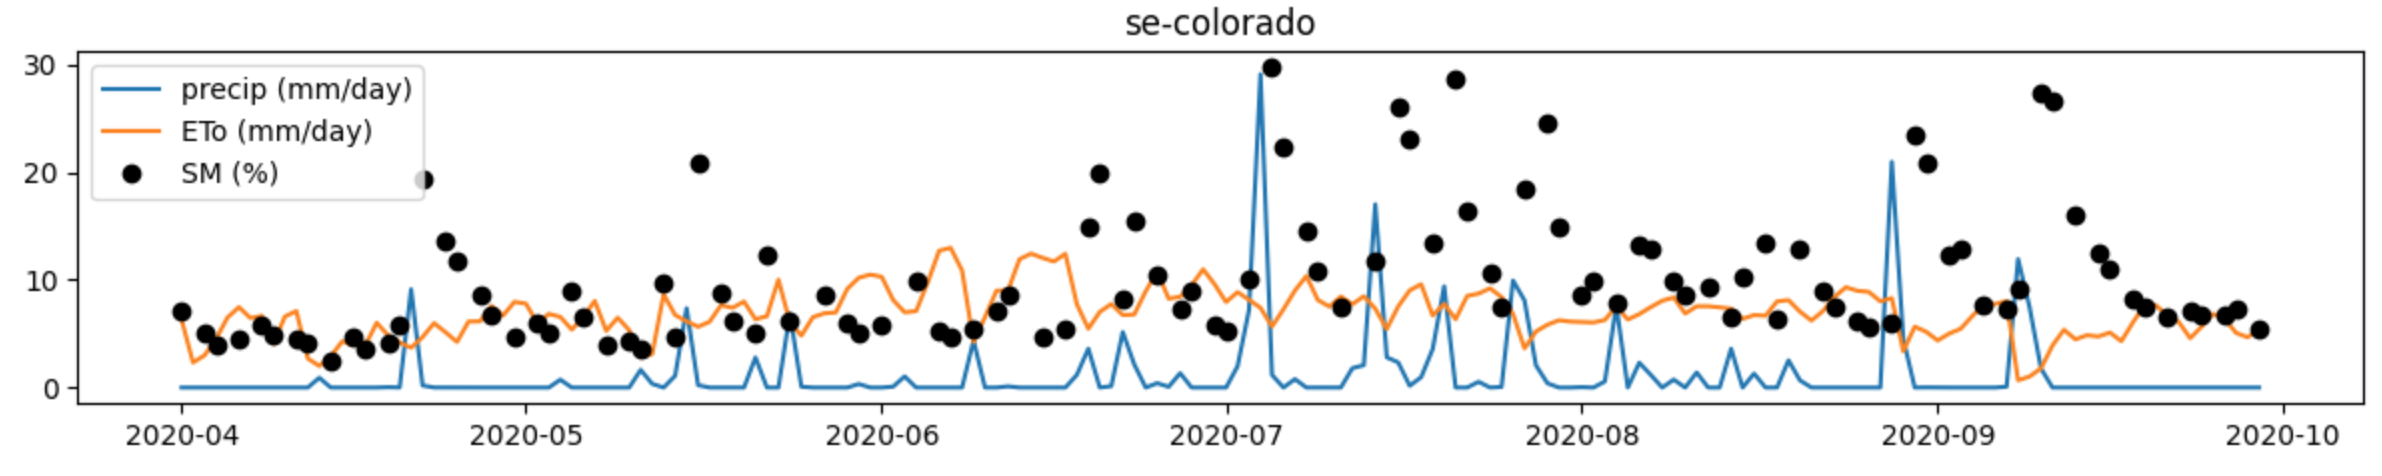

Choose one of the regions to make a map. Using the same method as lab 1, make a folium map of that region, along with average soil moisture, precipitation and ETo over the region. Take a screenshot of the map and include in your word document.

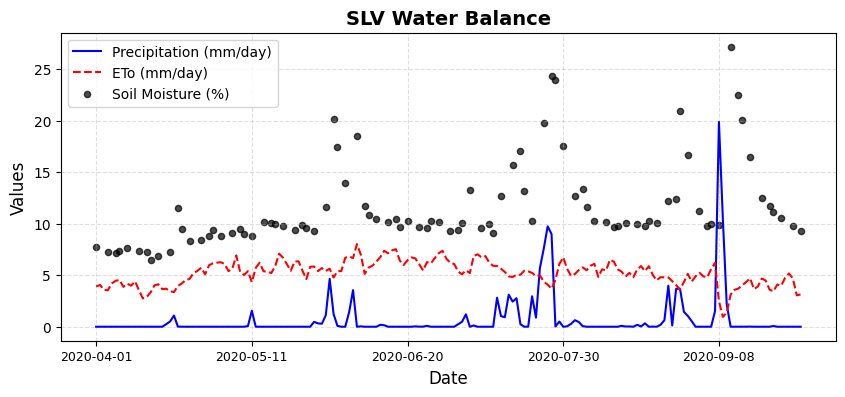


 SLV Summary Statistics 
 Total Precipitation (mm)  Total ETo (mm)  Precipitation - ETo (mm)  Precipitation / ETo  Avg. Soil Moisture (%)
                   120.46          944.96                   -824.50                 0.13                   11.57


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('slv-colorado_merged_data.csv')

# Create figure
plt.figure(figsize=(10, 4))

# Plot precipitation and ETo with different line styles
plt.plot(df['date'], df['pr'], label='Precipitation (mm/day)', linestyle='-', color='blue', linewidth=1.5)
plt.plot(df['date'], df['eto'], label='ETo (mm/day)', linestyle='--', color='red', linewidth=1.5)

# Scatter plot for soil moisture with increased size
plt.scatter(df['date'], df['soil_moisture_am'] * 100, label='Soil Moisture (%)', color='black', s=20, alpha=0.7)

# Labels and title with better readability
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('SLV Water Balance', fontsize=14, fontweight='bold')

# Improve x-axis formatting
plt.xticks(rotation=0, fontsize=9)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.4)

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.show()

# Compute summary statistics with improved formatting
summary_data = {
    'Total Precipitation (mm)': [df['pr'].sum()],
    'Total ETo (mm)': [df['eto'].sum()],
    'Precipitation - ETo (mm)': [df['pr'].sum() - df['eto'].sum()],
    'Precipitation / ETo': [df['pr'].sum() / df['eto'].sum()],
    'Avg. Soil Moisture (%)': [df['soil_moisture_am'].mean() * 100]  # Converted to percentage
}

# Create and display DataFrame with formatted output
SLVsummary_df = pd.DataFrame(summary_data)

print("\n SLV Summary Statistics ")
print(SLVsummary_df.to_string(index=False, float_format="%.2f"))

# Optional: Save to CSV
SLVsummary_df.to_csv('SLV_summary.csv', index=False)

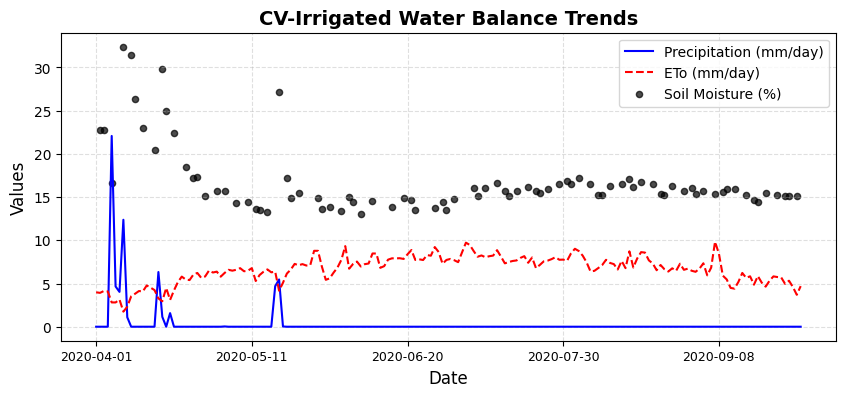


 CV-Irrigated Summary Statistics 
 Total Precipitation (mm)  Total ETo (mm)  Precipitation - ETo (mm)  Precipitation / ETo  Avg. Soil Moisture (%)
                    63.50         1205.13                  -1141.63                 0.05                   16.74


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('cv-irrigated_merged_data.csv')

# Create figure
plt.figure(figsize=(10, 4))

# Plot precipitation and ETo with different line styles
plt.plot(df['date'], df['pr'], label='Precipitation (mm/day)', linestyle='-', color='blue', linewidth=1.5)
plt.plot(df['date'], df['eto'], label='ETo (mm/day)', linestyle='--', color='red', linewidth=1.5)

# Scatter plot for soil moisture with increased size
plt.scatter(df['date'], df['soil_moisture_am'] * 100, label='Soil Moisture (%)', color='black', s=20, alpha=0.7)

# Labels and title with better readability
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('CV-Irrigated Water Balance Trends', fontsize=14, fontweight='bold')

# Improve x-axis formatting
plt.xticks(rotation=0, fontsize=9)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.4)

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.show()

# Compute summary statistics with improved formatting
summary_data = {
    'Total Precipitation (mm)': [df['pr'].sum()],
    'Total ETo (mm)': [df['eto'].sum()],
    'Precipitation - ETo (mm)': [df['pr'].sum() - df['eto'].sum()],
    'Precipitation / ETo': [df['pr'].sum() / df['eto'].sum()],
    'Avg. Soil Moisture (%)': [df['soil_moisture_am'].mean() * 100]  # Converted to percentage
}

# Create and display DataFrame with formatted output
CVsummary_df = pd.DataFrame(summary_data)

print("\n CV-Irrigated Summary Statistics ")
print(CVsummary_df.to_string(index=False, float_format="%.2f"))

# Optional: Save to CSV
CVsummary_df.to_csv('cv-irrigated_summary.csv', index=False)

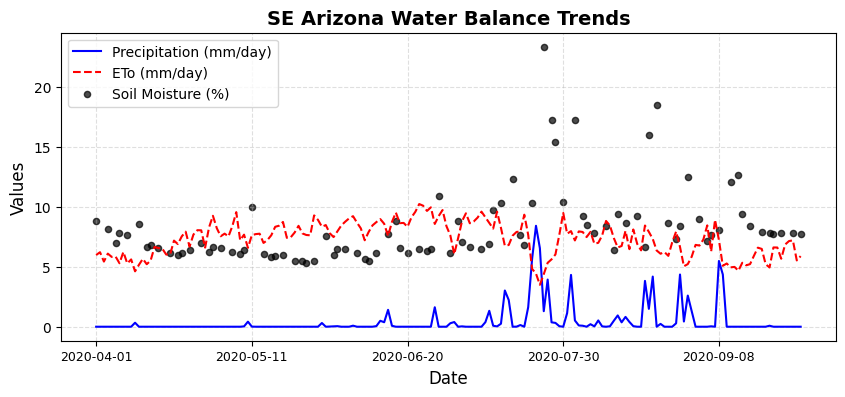


 SEAZ Summary Statistics 
 Total Precipitation (mm)  Total ETo (mm)  Precipitation - ETo (mm)  Precipitation / ETo  Avg. Soil Moisture (%)
                    63.50         1205.13                  -1141.63                 0.05                   16.74


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('se-arizona_merged_data.csv')

# Create figure
plt.figure(figsize=(10, 4))

# Plot precipitation and ETo with different line styles
plt.plot(df['date'], df['pr'], label='Precipitation (mm/day)', linestyle='-', color='blue', linewidth=1.5)
plt.plot(df['date'], df['eto'], label='ETo (mm/day)', linestyle='--', color='red', linewidth=1.5)

# Scatter plot for soil moisture with increased size
plt.scatter(df['date'], df['soil_moisture_am'] * 100, label='Soil Moisture (%)', color='black', s=20, alpha=0.7)

# Labels and title with better readability
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('SE Arizona Water Balance Trends', fontsize=14, fontweight='bold')

# Improve x-axis formatting
plt.xticks(rotation=0, fontsize=9)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.4)

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.show()

# Compute summary statistics with improved formatting
summary_data = {
    'Total Precipitation (mm)': [df['pr'].sum()],
    'Total ETo (mm)': [df['eto'].sum()],
    'Precipitation - ETo (mm)': [df['pr'].sum() - df['eto'].sum()],
    'Precipitation / ETo': [df['pr'].sum() / df['eto'].sum()],
    'Avg. Soil Moisture (%)': [df['soil_moisture_am'].mean() * 100]  # Converted to percentage
}

# Create and display DataFrame with formatted output
AZsummary_df = pd.DataFrame(summary_data)

print("\n SEAZ Summary Statistics ")
print(CVsummary_df.to_string(index=False, float_format="%.2f"))

# Optional: Save to CSV
SEAZsummary_df.to_csv('AZ_summary.csv', index=False)

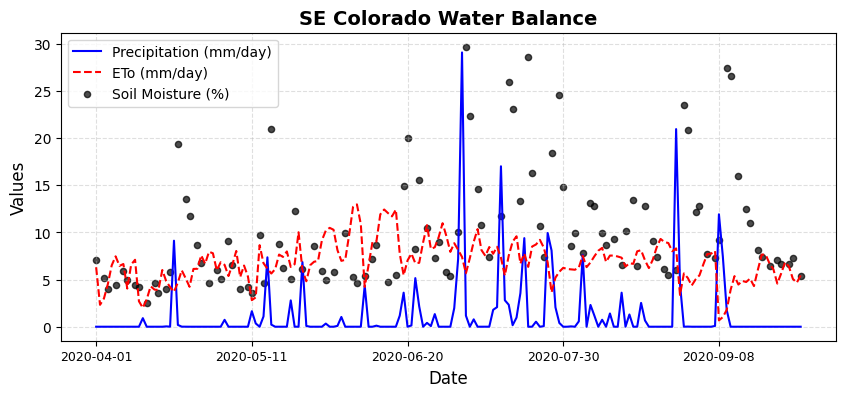


 SECO Summary Statistics 
 Total Precipitation (mm)  Total ETo (mm)  Precipitation - ETo (mm)  Precipitation / ETo  Avg. Soil Moisture (%)
                   221.50         1249.78                  -1028.28                 0.18                   10.06


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('se-colorado_merged_data.csv')

# Create figure
plt.figure(figsize=(10, 4))

# Plot precipitation and ETo with different line styles
plt.plot(df['date'], df['pr'], label='Precipitation (mm/day)', linestyle='-', color='blue', linewidth=1.5)
plt.plot(df['date'], df['eto'], label='ETo (mm/day)', linestyle='--', color='red', linewidth=1.5)

# Scatter plot for soil moisture with increased size
plt.scatter(df['date'], df['soil_moisture_am'] * 100, label='Soil Moisture (%)', color='black', s=20, alpha=0.7)

# Labels and title with better readability
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('SE Colorado Water Balance', fontsize=14, fontweight='bold')

# Improve x-axis formatting
plt.xticks(rotation=0, fontsize=9)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.4)

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.show()

# Compute summary statistics with improved formatting
summary_data = {
    'Total Precipitation (mm)': [df['pr'].sum()],
    'Total ETo (mm)': [df['eto'].sum()],
    'Precipitation - ETo (mm)': [df['pr'].sum() - df['eto'].sum()],
    'Precipitation / ETo': [df['pr'].sum() / df['eto'].sum()],
    'Avg. Soil Moisture (%)': [df['soil_moisture_am'].mean() * 100]  # Converted to percentage
}

# Create and display DataFrame with formatted output
SECOsummary_df = pd.DataFrame(summary_data)

print("\n SECO Summary Statistics ")
print(SECOsummary_df.to_string(index=False, float_format="%.2f"))

# Optional: Save to CSV
SEAZsummary_df.to_csv('SECO_summary.csv', index=False)

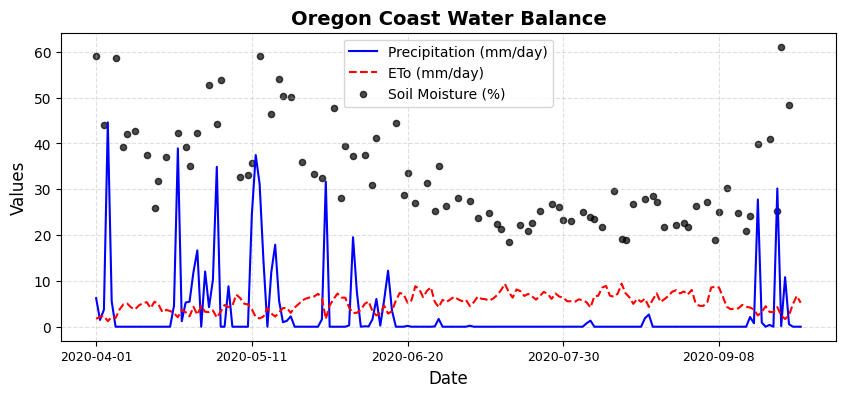


 Oregon Coast Summary Statistics 
 Total Precipitation (mm)  Total ETo (mm)  Precipitation - ETo (mm)  Precipitation / ETo  Avg. Soil Moisture (%)
                    63.50         1205.13                  -1141.63                 0.05                   16.74


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('oregon-coast_merged_data.csv')

# Create figure
plt.figure(figsize=(10, 4))

# Plot precipitation and ETo with different line styles
plt.plot(df['date'], df['pr'], label='Precipitation (mm/day)', linestyle='-', color='blue', linewidth=1.5)
plt.plot(df['date'], df['eto'], label='ETo (mm/day)', linestyle='--', color='red', linewidth=1.5)

# Scatter plot for soil moisture with increased size
plt.scatter(df['date'], df['soil_moisture_am'] * 100, label='Soil Moisture (%)', color='black', s=20, alpha=0.7)

# Labels and title with better readability
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Oregon Coast Water Balance', fontsize=14, fontweight='bold')

# Improve x-axis formatting
plt.xticks(rotation=0, fontsize=9)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.4)

# Add legend
plt.legend(fontsize=10)

# Show the plot
plt.show()

# Compute summary statistics with improved formatting
summary_data = {
    'Total Precipitation (mm)': [df['pr'].sum()],
    'Total ETo (mm)': [df['eto'].sum()],
    'Precipitation - ETo (mm)': [df['pr'].sum() - df['eto'].sum()],
    'Precipitation / ETo': [df['pr'].sum() / df['eto'].sum()],
    'Avg. Soil Moisture (%)': [df['soil_moisture_am'].mean() * 100]  # Converted to percentage
}

# Create and display DataFrame with formatted output
ORsummary_df = pd.DataFrame(summary_data)

print("\n Oregon Coast Summary Statistics ")
print(CVsummary_df.to_string(index=False, float_format="%.2f"))

# Optional: Save to CSV
SEAZsummary_df.to_csv('OR_summary.csv', index=False)

In [30]:
import pandas as pd

# List of dataframes and their corresponding region names
dfs = [ORsummary_df, SECOsummary_df, AZsummary_df, CVsummary_df, SLVsummary_df]
regions = ['Oregon', 'SE Colorado', 'Arizona', 'Central Valley', 'San Luis Valley']

# Add a 'Region' column to each dataframe before concatenating
for df, region in zip(dfs, regions):
    df['Region'] = region  # Assign region name

# Combine all dataframes into one
summary_stats = pd.concat(dfs, ignore_index=True)

# Reorder columns to have 'Region' first for readability
summary_stats = summary_stats[['Region'] + [col for col in summary_stats.columns if col != 'Region']]

# Display the combined dataframe
print(summary_stats)

# Optional: Save to CSV
summary_stats.to_csv('combined_summary_stats.csv', index=False)

            Region  Total Precipitation (mm)  Total ETo (mm)  \
0           Oregon                535.595479      944.344755   
1      SE Colorado                221.498119     1249.780303   
2          Arizona                 80.549750     1336.934712   
3   Central Valley                 63.499934     1205.126903   
4  San Luis Valley                120.457979      944.958136   

   Precipitation - ETo (mm)  Precipitation / ETo  Avg. Soil Moisture (%)  \
0               -408.749276             0.567161               32.964855   
1              -1028.282183             0.177230               10.058562   
2              -1256.384962             0.060250                8.285614   
3              -1141.626969             0.052691               16.738645   
4               -824.500157             0.127474               11.571287   

              area  
0           Oregon  
1      SE Colorado  
2          Arizona  
3   Central Valley  
4  San Luis Valley  


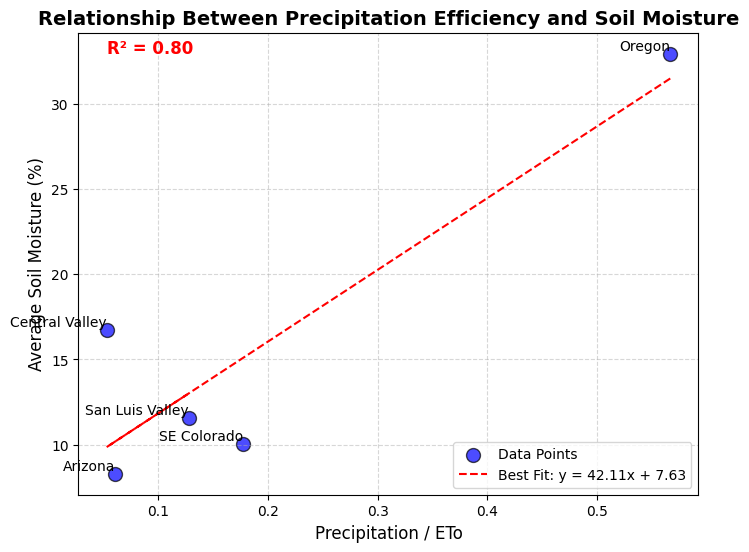

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
x = summary_stats['Precipitation / ETo']
y = summary_stats['Avg. Soil Moisture (%)']
regions = summary_stats['Region']

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', s=100, alpha=0.7, edgecolors='black', label="Data Points")

# Add region labels to each point
for i, region in enumerate(regions):
    plt.text(x[i], y[i], region, fontsize=10, ha='right', va='bottom', color='black')

# Best-fit line (linear regression)
m, b = np.polyfit(x, y, 1)  # Fit line (slope, intercept)
plt.plot(x, m*x + b, color='red', linestyle='--', label=f'Best Fit: y = {m:.2f}x + {b:.2f}')

# Compute R² value
y_pred = m*x + b
r_squared = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
plt.text(min(x), max(y), f'R² = {r_squared:.2f}', fontsize=12, color='red', fontweight='bold')

# Labels and title
plt.xlabel('Precipitation / ETo', fontsize=12)
plt.ylabel('Average Soil Moisture (%)', fontsize=12)
plt.title('Relationship Between Precipitation Efficiency and Soil Moisture', fontsize=14, fontweight='bold')

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure correct data types and handle potential NaN values
summary_stats = summary_stats.dropna(subset=['Precipitation - ETo', 'Avg. Soil Moisture (%)'])

# Extract data for plotting
x = summary_stats['Precipitation - ETo'].to_numpy()
y = summary_stats['Avg. Soil Moisture (%)'].to_numpy()
regions = summary_stats['Region'].to_list()

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', s=100, alpha=0.7, edgecolors='black', label="Data Points")

# Add region labels to each point
for i, region in enumerate(regions):
    plt.text(x[i], y[i], region, fontsize=10, ha='right', va='bottom', color='black')

# Best-fit line (linear regression)
if len(x) > 1:  # Avoid fitting if there's only one point
    m, b = np.polyfit(x, y, 1)  # Fit line (slope, intercept)
    plt.plot(x, m*x + b, color='red', linestyle='--', label=f'Best Fit: y = {m:.2f}x + {b:.2f}')

    # Compute R² value
    y_pred = m*x + b
    r_squared = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
    plt.text(min(x), max(y), f'R² = {r_squared:.2f}', fontsize=12, color='red', fontweight='bold')

# Labels and title
plt.xlabel('Precipitation - ETo', fontsize=12)
plt.ylabel('Average Soil Moisture (%)', fontsize=12)
plt.title('Precipitation - ETo vs Soil Moisture', fontsize=14, fontweight='bold')

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

KeyError: ['Precipitation - ETo']

In [29]:
# Assign area names to each summary dataframe
ORsummary_df['area'] = 'Oregon'
SECOsummary_df['area'] = 'SE Colorado'
AZsummary_df['area'] = 'Arizona'
CVsummary_df['area'] = 'Central Valley'
SLVsummary_df['area'] = 'San Luis Valley'

# Combine all summaries into one DataFrame
summary_stats = pd.concat([ORsummary_df, SECOsummary_df, AZsummary_df, CVsummary_df, SLVsummary_df], ignore_index=True)

# Reorder columns for clarity (area first)
summary_stats = summary_stats[['area', 'total_precipitation', 'total_eto', 'precipitation_minus_eto',
                               'precipitation_div_eto', 'average_soil_moisture']]

# Display result
print(summary_stats)

KeyError: "['total_precipitation', 'total_eto', 'precipitation_minus_eto', 'precipitation_div_eto', 'average_soil_moisture'] not in index"

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extract x and y values
x = summary_stats['precipitation_div_eto']
y = summary_stats['average_soil_moisture']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate best-fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='b', edgecolors='k', label='Data points')

# Plot best-fit line
plt.plot(x_fit, y_fit, 'r-', label=f'Best fit (R² = {r_value**2:.2f})')

# Add labels for each point
for i, area in enumerate(summary_stats['area']):
    plt.text(x[i], y[i], area, fontsize=10, ha='right')

# Labels and title
plt.xlabel('Precip / ETo')
plt.ylabel('Average Soil Moisture')
plt.title('Precip/ETo vs Soil Moisture')

# Show grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Display plot
plt.show()

KeyError: 'precipitation_div_eto'

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extract x and y values
x = summary_stats['precipitation_minus_eto']
y = summary_stats['average_soil_moisture']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate best-fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='b', edgecolors='k', label='Data points')

# Plot best-fit line
plt.plot(x_fit, y_fit, 'r-', label=f'Best fit (R² = {r_value**2:.2f})')

# Add labels for each point
for i, area in enumerate(summary_stats['area']):
    plt.text(x[i], y[i], area, fontsize=10, ha='right')

# Labels and title
plt.xlabel('Precip - ETo mm')
plt.ylabel('Avg Soil Moisture %')
plt.title('Precip-ETo vs Soil Moisture')

# Show grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Display plot
plt.show()

KeyError: 'precipitation_minus_eto'

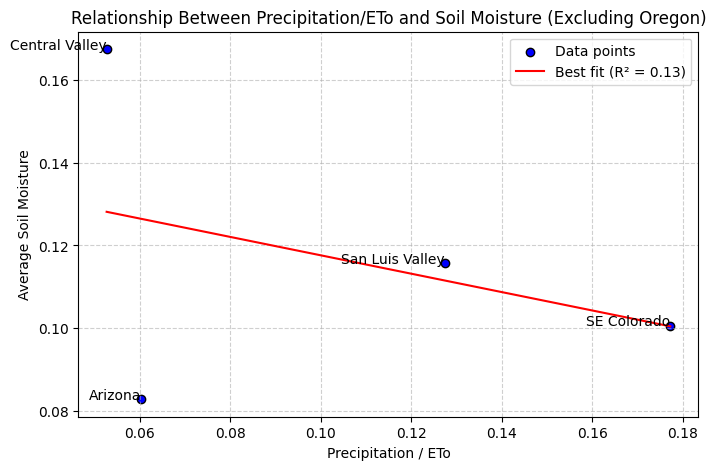

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Exclude Oregon
filtered_summary = summary_stats[summary_stats['area'] != 'Oregon']

# Extract x and y values
x = filtered_summary['precipitation_div_eto']
y = filtered_summary['average_soil_moisture']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate best-fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='b', edgecolors='k', label='Data points')

# Plot best-fit line
plt.plot(x_fit, y_fit, 'r-', label=f'Best fit (R² = {r_value**2:.2f})')

# Add labels for each point
for i, area in enumerate(filtered_summary['area']):
    plt.text(x.iloc[i], y.iloc[i], area, fontsize=10, ha='right')

# Labels and title
plt.xlabel('Precipitation / ETo')
plt.ylabel('Average Soil Moisture')
plt.title('Relationship Between Precipitation/ETo and Soil Moisture (Excluding Oregon)')

# Show grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Display plot
plt.show()

In [57]:
import geopandas as gpd

# Load the shapefile
shapefile_path = '/content/Pantanal_HW3 shapefile.shp'
gdf = gpd.read_file(shapefile_path)
print(gdf.head)



<bound method NDFrame.head of    id                                           geometry
0   0  POLYGON ((-58.00984 -19.35991, -58.02508 -19.3...>


In [ ]:
# create a bounding box that defines the study area
# geom = addGeometry(-109, -102,37,41) # min long, max long, min lat, max lat (colorado)
geom = addGeometry(-106.28894, -105.6693,37.87336,37.88) # min long, max long, min lat, max lat (kansas)

# define dates of interest (inclusive).
start = '2020-04-01'
end = '2020-09-01' #can go up to april 2021

# get elevation data
elev = get_elev(geom)

# now get gpm precipitation over the same region for a specified time period
#  use get_imgcollection to create variable gpm_img (mean precip)
gpm_img = get_imgcollection(start,end,geom,'IDAHO_EPSCOR/GRIDMET','pr','mean')

# now get prism precipitation over the same time period/region
prism_img = get_imgcollection(start,end,geom,'OREGONSTATE/PRISM/AN81m','ppt','mean')

gridmet_ppt = gee_zonal_mean(start,end,watershed_gee.geometry(),'IDAHO_EPSCOR/GRIDMET','pr',scale=10000)
  gridmet_ppt = gridmet_ppt[['pr','date']].set_index('date')
  gridmet_ppt.index = gridmet_ppt.index.to_period('D')

In [56]:
import geopandas as gpd
import folium
import pandas as pd

# Load the shapefile
shapefile_path = '/content/remote-sensing-hydro-2025/data/hw3/slv-colorado.shp'
gdf = gpd.read_file(shapefile_path)

# Load the CSV file containing precipitation, ETo, and soil moisture data
data_path = '/content/slv-colorado_merged_data.csv'
df = pd.read_csv(data_path, parse_dates=['date'])

# Ensure required columns exist
if {'pr', 'eto', 'soil_moisture_am'}.issubset(df.columns):
    # Compute mean values
    mean_pr = df['pr'].mean()
    mean_eto = df['eto'].mean()
    mean_soil_moisture = df['soil_moisture_am'].mean()
else:
    raise ValueError("CSV file is missing one or more required columns: 'pr', 'eto', 'soil_moisture_am'")

# Get the center of the shapefile for map centering
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Create a Folium map centered on the area
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add shapefile geometry
folium.GeoJson(gdf, name="SLV Colorado").add_to(my_map)

# Create individual layers
pr_layer = folium.FeatureGroup(name="Mean Precipitation (mm/day)")
eto_layer = folium.FeatureGroup(name="Mean ETo (mm/day)")
soil_moisture_layer = folium.FeatureGroup(name="Mean Soil Moisture (m³/m³)")

# Add markers with mean values
folium.Marker(
    [center_lat, center_lon],
    popup=f"Mean Precipitation: {mean_pr:.2f} mm/day",
    tooltip="Precipitation Info",
    icon=folium.Icon(color="blue", icon="cloud")
).add_to(pr_layer)

folium.Marker(
    [center_lat, center_lon],
    popup=f"Mean ETo: {mean_eto:.2f} mm/day",
    tooltip="ETo Info",
    icon=folium.Icon(color="green", icon="leaf")
).add_to(eto_layer)

folium.Marker(
    [center_lat, center_lon],
    popup=f"Mean Soil Moisture: {mean_soil_moisture:.3f} m³/m³",
    tooltip="Soil Moisture Info",
    icon=folium.Icon(color="orange", icon="tint")
).add_to(soil_moisture_layer)

# Add layers to map
pr_layer.add_to(my_map)
eto_layer.add_to(my_map)
soil_moisture_layer.add_to(my_map)

# Add layer control
folium.LayerControl().add_to(my_map)

# Display the map
my_map

# Part 2: repeat this analysis over your own study area
First, upload a shapefile of your study area or a portion of your study area to the files directory. Be sure to include ALL FILES WITH THE SAME STEM (.shp, .dbf, .prj, .shx, etc). Make a note of the path to your shapefile. If you put it in the main directory it should just be 'filename.shp' or whatever you named it.

Then, repeat the analysis performed in part 1 over your study area. In most cases, you can just copy and paste code from the appropriate section.

In [37]:
start='2015-01-01'
end='2025-01-01'
shapefile='</content/Pantanal_HW3 shapefile.shp>.shp'

In [38]:
# upload watershed to GEE----------------------------
shapefile = geemap.shp_to_ee('</content/Pantanal_HW3 shapefile.shp>')

The input shapefile could not be found.
